# Лабараторная работа 2
Троицкий Тимофей ПМ-32  
***Вариант 3***


In [20]:
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from tabulate import tabulate
from IPython.display import display

# Описание файлов проекта

## Основные файлы с кодом

- **`1.cpp`**  
  Реализация первых 4 заданий:
  - `first_task` - скомпилированная программа для заданий 1-3
  - `4_task` - скомпилированная программа для задания 4

- **`5.cpp`**  
  Файл для заданий 5-7 (скомпилирован в `5_task`):
  - Чтение векторов из `5_task_convol.bin`
  - Запись результатов в:
    - `convol_result_direct.bin` (прямая свертка)
    - `convol_result_fft.bin` (свертка через БПФ)

- **`8.cpp`**  
  Программа для 8 задания (скомпилирована в `8_task`):
  - Замер времени выполнения сверток
  - Использует сигналы из файлов `convol_...`

## Вспомогательные файлы

- **`binary_file_signal.bin`**  
  Исходный сигнал для задания 1

- **`FFT_task.bin`**  
  Файл для сравнения векторов с Python-реализацией (задание 3)

## Директории

- **`signal_in_4ex/`**  
  Содержит сгенерированные сигналы для 4 задания

- **`convol/`**  
  Cодержит входные сигналы для 8 задания

## Пункт 1 


### Реализовать на С или С++ алгоритмы непосредственного вычисления ДПФ и ОДПФ для комплексного дискретного сигнала с двойной точностью (double). Входные данные загружать из бинарного файла, сгенерированного в MATLAB или Python.

### Дискретное преобразование Фурье (ДПФ)

**Определение**:  
Для вектора $X = (x_0, x_1, \ldots, x_{N-1})$ **дискретным спектром** (ДПФ) называется вектор $Y = (y_0, y_1, \ldots, y_{N-1})$, компоненты которого вычисляются по формуле:  

$$
y_k = \frac{1}{N} \sum_{j=0}^{N-1} x_j e^{-\frac{2\pi i}{N} k j}, \quad k = 0, \ldots, N-1.
$$  

*(где $e^{-\frac{2\pi i}{N} k j}$ — комплексная экспонента)*  

---

### Обратное ДПФ (ОДПФ)  
Исходный вектор $X$ восстанавливается из спектра $Y$ с помощью **обратного ДПФ**:  

$$
x_j = \sum_{k=0}^{N-1} y_k e^{\frac{2\pi i}{N} k j}, \quad j = 0, \ldots, N-1.
$$  


In [52]:
N = 1024
signal_baze = np.random.rand(N) + 1j * np.random.rand(N)

with open("binary_file_signal.bin", "wb") as f:
    f.write(np.int32(N))
    f.write(signal_baze.astype(np.complex128).tobytes())

### Реализация на с++



```cpp
// -------------  ДПФ и ОДПФ --------------------------------

class FourierTransformer {
public:
    static vector<complex<double>> transform(const vector<complex<double>>& signal) {
        return compute(signal, -1);
    }

    static vector<complex<double>> inverseTransform(const vector<complex<double>>& signal) {
        return compute(signal, 1);
    }

private:
    static vector<complex<double>> compute(const vector<complex<double>>& signal, int direction) {
        const size_t N = signal.size();
        vector<complex<double>> result(N);
        const double norm = sqrt(N);

        for (size_t k = 0; k < N; ++k) {
            result[k] = 0;
            for (size_t n = 0; n < N; ++n) {
                const double angle = direction * 2 * M_PI * k * n / N;
                result[k] += signal[n] * polar(1.0, angle);
            }
            result[k] /= norm;
        }

        return result;
    }
};

// Обратная перестановка битов
unsigned int reverseBits(unsigned int x, int bitCount) {
    unsigned int reversed = 0;
    while (bitCount--) {
        reversed = (reversed << 1) | (x & 1);
        x >>= 1;
    }
    return reversed;
}
```

## Пункт 2



### Реализовать на С или С++ алгоритмы прямого и обратного БПФ для комплексного дискретного сигнала длиной $N=2^n$, где n – любое натуральное число.
***В моём случае это будет: с прореживанием по частоте и двоично-инверсными перестановками***

### 1. Вычисление БПФ (основной цикл)
**Цикл по матрицам**:  
Для $k = 1, \ldots, n$:  
- **Цикл по блокам** $\left[ \mathbf{B}_n^{(j)} \right]^T$, где $j = 0, \ldots, 2^{k-1} - 1$  
- **Цикл по столбцам** $\left[ \mathbf{B}_{n+1-k}^{(j)} \right]^T$, $l = 0, \ldots, 2^{n-k} - 1$  

**Формулы обновления**:  
$$
y(j2^{n+1-k} + l) = x(j2^{n+1-k} + l) + x(j2^{n+1-k} + l + 2^{n-k})
$$  
$$
y(j2^{n+1-k} + l + 2^{n-k}) = \left(x(j2^{n+1-k} + l) - x(j2^{n+1-k} + l + 2^{n-k})\right) \omega_{n+1-k}^l
$$  

**Обновление**:  
$$ \mathbf{X} \leftarrow \mathbf{Y} $$

---

### 2. Перестановка компонент
Попарная перестановка элементов вектора $\mathbf{Y}$ с двоично-инверсными индексами:  
$$ \mathbf{Y} \leftarrow \mathbf{CY} $$  
*(Где $\mathbf{C}$ — матрица перестановок)*

---

### 3. Нормировка результата
Деление на $\sqrt{N}$:  
$$ \mathbf{Y} \leftarrow \frac{1}{\sqrt{N}} \mathbf{Y} $$

**Итог**: Вектор $\mathbf{Y}$ содержит результат БПФ.

### Реализация на с++


```cpp
// ----------------------- БПФ и ОБПФ --------------------------

// Общая часть для БПФ и ОБПФ
void butterflyTransform(vector<complex<double>>& data, double sign) {
    const int n = data.size();
    const int log2n = log2(n);
    
    // Перестановка элементов
    vector<complex<double>> temp(n);
    for (int i = 0; i < n; ++i) 
        temp[reverseBits(i, log2n)] = data[i];
    data = temp;

    // Алгоритм бабочки
    for (int stage = 1; stage <= log2n; ++stage) {
        int m = 1 << stage;
        int half_m = m/2;
        complex<double> wm = exp(complex<double>(0, sign * 2 * M_PI / m));
        
        for (int k = 0; k < n; k += m) {
            complex<double> w = 1.0;
            for (int j = 0; j < half_m; ++j) {
                auto t = w * data[k + j + half_m];
                auto u = data[k + j];
                data[k + j] = u + t;
                data[k + j + half_m] = u - t;
                w *= wm;
            }
        }
    }
}

// Прямое БПФ с нормировкой
vector<complex<double>> FFT(vector<complex<double>> signal) {
    butterflyTransform(signal, -1.0);
    
    const double norm = sqrt(signal.size());
    transform(signal.begin(), signal.end(), signal.begin(), 
             [norm](auto x) { return x / norm; });
             
    return signal;
}

// Обратное БПФ с нормировкой
vector<complex<double>> IFFT(vector<complex<double>> spectrum) {
    butterflyTransform(spectrum, 1.0);
    
    const double norm = sqrt(spectrum.size());
    transform(spectrum.begin(), spectrum.end(), spectrum.begin(),
             [norm](auto x) { return x / norm; });
             
    return spectrum;
}

// Проверка степени двойки
bool isPowerOfTwo(int n) {
    return n > 0 && (n & (n - 1)) == 0;
}

// Чтение сигнала из файла
vector<complex<double>> readSignal(const string& filename) {
    ifstream file(filename, ios::binary);
    if (!file) throw runtime_error("File error");

    int size;
    file.read(reinterpret_cast<char*>(&size), sizeof(int));
    
    vector<complex<double>> data(size);
    file.read(reinterpret_cast<char*>(data.data()), size * sizeof(complex<double>));
    
    return data;
}

// Запись сигнала в файл
void writeSignal(const string& filename, const vector<complex<double>>& data) {
    ofstream file(filename, ios::binary);
    if (!file) throw runtime_error("File error");

    const int size = data.size();
    file.write(reinterpret_cast<const char*>(&size), sizeof(int));
    file.write(reinterpret_cast<const char*>(data.data()), size * sizeof(complex<double>));
}

vector<complex<double>> readSignalData(const string& filename) {
    ifstream file(filename, ios::binary);
    if (!file) throw runtime_error("Файл не открылся");

    int size;
    file.read(reinterpret_cast<char*>(&size), sizeof(int));
    
    vector<complex<double>> data(size);
    file.read(reinterpret_cast<char*>(data.data()), size * sizeof(complex<double>));
    
    return data;
}

void max_error(const std::vector<std::complex<double>>& signal, const std::vector<std::complex<double>>& ẋ)
{
    double Real = 0.0;
    double Im = 0.0;
    for (int i = 0; i < signal.size(); ++i) {
        double realDiff = abs(ẋ[i].real() - signal[i].real());
        double imagDiff = abs(ẋ[i].imag() - signal[i].imag());
        
        if (realDiff > Real) {
            Real = realDiff;
        }
        
        if (imagDiff > Im) {
            Im = imagDiff;
        }
    }

    
    cout << "Отклонение: " << endl;
    cout << "Вещественная часть: " << Real << endl;
    cout << "Мнимая: " << Im << endl;

}
```

## Пункт 3

### Убедиться в корректности работы алгоритмов, используя дискретный сигнал $X$ длины $N=2^{10}$:

#### 1. Проверить выполнение равенства **X = ОДПФ(ДПФ(X))**, а также равенства **X = ОБПФ(БПФ(X))**;
#### 2. Сравнить результаты **ДПФ(X) и БПФ(X)**;
#### 3. Сравнить результаты работы реализованного алгоритма, с результатами выполнения встроенных функций: fft в MATLAB или numpy.fft.fft в Python. Для сравнения результатов найти норму разности вычисленных векторов ДПФ.
---
##### 1.
Проверка X = ОДПФ(ДПФ(X))

По сути нужно посмотреть насколько изменился наш конечный вектор по сравнению с исходным


![Снимок экрана от 2025-05-17 21-33-48.png](<attachment:Снимок экрана от 2025-05-17 21-33-48.png>)
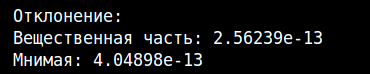

Проверка X = ОБПФ(БПФ(X))

![Снимок экрана от 2025-05-17 21-34-33.png](<attachment:Снимок экрана от 2025-05-17 21-34-33.png>)
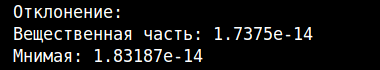

##### 2.

![Снимок экрана от 2025-05-17 22-35-20.png](<attachment:Снимок экрана от 2025-05-17 22-35-20.png>)
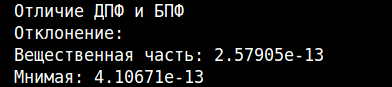

**Из этих данных видно, что отклонение почти не отличаются(-13 степень это довольно точный результат)**  

---

##### 3.

In [56]:
# Чтение результатов БПФ из бинарного файла
filename = "FFT_task.bin" # Файл с преобразованным сигналом
with open(filename, "rb") as file:
    signal_length = np.frombuffer(file.read(4), dtype=np.int32)[0]
    frequency_domain = np.frombuffer(file.read(), dtype=np.complex128, count=signal_length)

numpy_reference = np.fft.fft(signal_baze, norm='ortho')
max_difference = np.max(np.abs(frequency_domain - numpy_reference))

print("\nСравнение с эталонной реализацией:")
print(f"Максимальная разница с np.fft.fft: {max_difference}")


Сравнение с эталонной реализацией:
Максимальная разница с np.fft.fft: 1.3364821239442366e-14


## Пункт 4

### Построить графики зависимости времени выполнения БПФ и непосредственного вычисления ДПФ от длины 𝑁 преобразования. Рассмотреть последовательности длины $N=2^{n}$, n ∈ {6,7, … ,12}. Сделать вывод о сложности алгоритмов для обоих методов вычисления

In [ ]:
# Параметры сигнала
signal_length_exp = [6, 7,8, 9, 10, 11, 12]
for i in signal_length_exp:
    signal_length = 2 ** i  # Длина сигнала
    signal = np.random.rand(signal_length) + 1j * np.random.rand(signal_length)
    string = "index_of_exponent_" + str(i) + ".bin"
    with open(string, "wb") as f:
        f.write(np.int32(signal_length))
        f.write(signal.astype(np.complex128).tobytes())
    print(string)

index_of_exponent_6.bin
index_of_exponent_7.bin
index_of_exponent_8.bin
index_of_exponent_9.bin
index_of_exponent_10.bin
index_of_exponent_11.bin
index_of_exponent_12.bin


#### Консольный вывод нашей программы 4_task

![Снимок экрана от 2025-05-18 16-12-58.png](<attachment:Снимок экрана от 2025-05-18 16-12-58.png>)
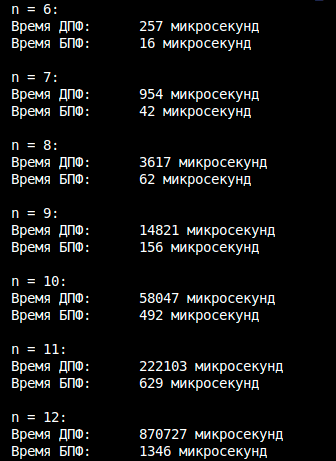

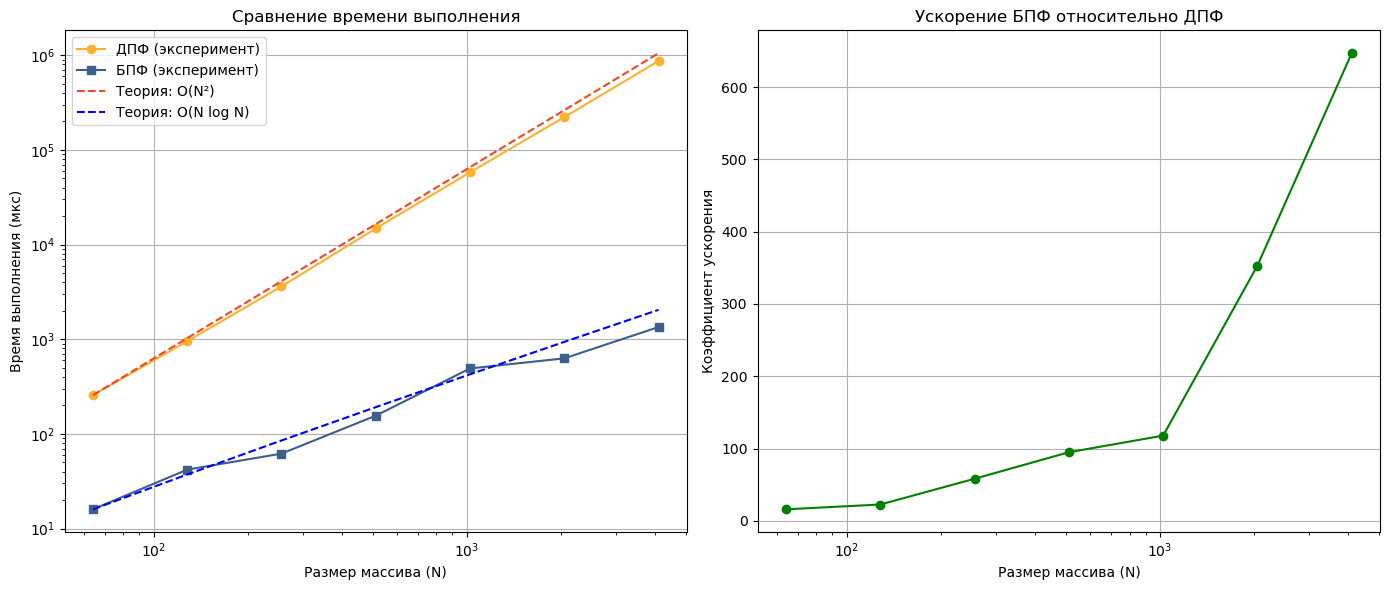

Анализ производительности:
N=2ⁿ     | N        | ДПФ (мкс)  | БПФ (мкс)  | Ускорение 
------------------------------------------------------------
6        | 64       | 257.000    | 16.000     | 16.1      
7        | 128      | 954.000    | 42.000     | 22.7      
8        | 256      | 3617.000   | 62.000     | 58.3      
9        | 512      | 14821.000  | 156.000    | 95.0      
10       | 1024     | 58047.000  | 492.000    | 118.0     
11       | 2048     | 222103.000 | 629.000    | 353.1     
12       | 4096     | 870727.000 | 1346.000   | 646.9     

Оценка сложности алгоритмов:
ДПФ: При увеличении N в 2 раза время увеличивается в ~3.9 раза (теория: ~4)
БПФ: При увеличении N в 2 раза время увеличивается в ~2.2 раза (теория: ~2)


In [54]:
# Данные измерений
index_of_exponent = np.array([6, 7, 8, 9, 10, 11, 12])  # Степени двойки
N_values = 2**index_of_exponent  # Значения N
time_dft = np.array([257, 954, 3617, 14821, 58047, 222103, 870727])  # микросекунд
time_fft = np.array([16, 42, 62, 156, 492, 629, 1346])  # микросекунд

speedup = time_dft / time_fft

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(N_values, time_dft, 'o-', color='#ffb02e', label='ДПФ (эксперимент)')
plt.plot(N_values, time_fft, 's-', color='#3e5f8a', label='БПФ (эксперимент)')

# Теоретические кривые (нормализованные для сравнения)
n_squared = N_values**2 / (N_values[0]**2) * time_dft[0]  # O(n²)
n_log_n = N_values * np.log2(N_values) / (N_values[0] * np.log2(N_values[0])) * time_fft[0]  # O(n log n)

plt.plot(N_values, n_squared, '--', color='#f34723', label='Теория: O(N²)')
plt.plot(N_values, n_log_n, '--', color='blue', label='Теория: O(N log N)')

plt.xlabel('Размер массива (N)')
plt.ylabel('Время выполнения (мкс)')
plt.title('Сравнение времени выполнения')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 2, 2)
plt.plot(N_values, speedup, 'o-', color='green')
plt.xlabel('Размер массива (N)')
plt.ylabel('Коэффициент ускорения')
plt.title('Ускорение БПФ относительно ДПФ')
plt.grid(True)
plt.xscale('log')

plt.tight_layout()
plt.show()

print("Анализ производительности:")
print(f"{'N=2ⁿ':<8} | {'N':<8} | {'ДПФ (мкс)':<10} | {'БПФ (мкс)':<10} | {'Ускорение':<10}")
print("-"*60)
for n, N, td, tf in zip(index_of_exponent, N_values, time_dft, time_fft):
    print(f"{n:<8} | {N:<8} | {td:<10.3f} | {tf:<10.3f} | {td/tf:<10.1f}")

print("\nОценка сложности алгоритмов:")
print(f"ДПФ: При увеличении N в 2 раза время увеличивается в ~{np.mean(time_dft[1:]/time_dft[:-1]):.1f} раза (теория: ~4)")
print(f"БПФ: При увеличении N в 2 раза время увеличивается в ~{np.mean(time_fft[1:]/time_fft[:-1]):.1f} раза (теория: ~2)")

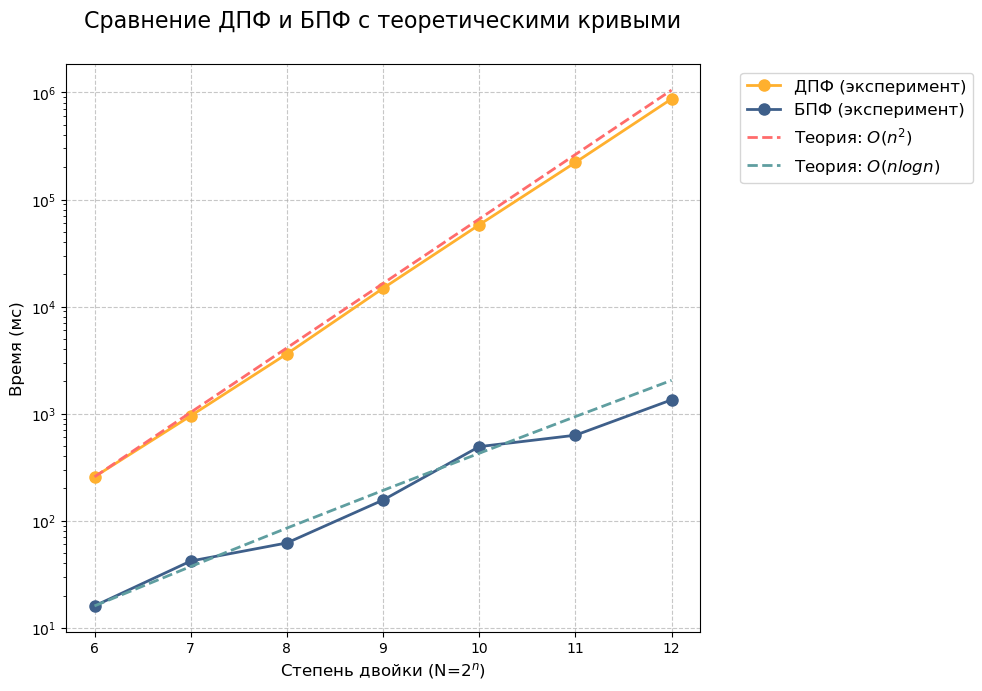

In [55]:
N = np.arange(6, 13)
n_values = 2**N
n_squared = (n_values**2) / (n_values[0]**2) * time_dft[0]
n_log_n = (n_values * np.log2(n_values)) / (n_values[0] * np.log2(n_values[0])) * time_fft[0]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 7))

# Экспериментальные данные
ax1.semilogy(N, time_dft, 'o-', color='#ffb02e', linewidth=2, markersize=8, label='ДПФ (эксперимент)')
ax1.semilogy(N, time_fft, 'o-', color='#3e5f8a', linewidth=2, markersize=8, label='БПФ (эксперимент)')

# Теоретические кривые
ax1.semilogy(N, n_squared, '--', color='#ff6b6b', linewidth=2, label='Теория: $O(n^2)$')
ax1.semilogy(N, n_log_n, '--', color='#5f9ea0', linewidth=2, label='Теория: $O(n log n)$')

ax1.set_xlabel('Степень двойки (N=2$^n$)', fontsize=12)
ax1.set_ylabel('Время (мс)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Сравнение ДПФ и БПФ с теоретическими кривыми', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

#### Экспериментальные данные демонстрируют асимптотическое поведение, соответствующее теоретическим оценкам сложности

## Пункт 5

### Реализовать процедуру прямого вычисления свертки двух последовательностей по формуле $u_n = \sum \limits_{k=0}^{\infty} x_k y_{n-k}$

In [58]:
N = 1024
X = np.random.rand(N) + 1j * np.random.rand(N)
Y = np.random.rand(N) + 1j * np.random.rand(N)

file_path = "5_task_convol.bin"

with open(file_path, "wb") as f:
    f.write(np.int32(N))
    f.write(X.astype(np.complex128).tobytes())
    f.write(Y.astype(np.complex128).tobytes())
# Записали наши сигналы в файл

```cpp
#define MEASURE_TIME(code) \
    do { \
        auto start = std::chrono::high_resolution_clock::now(); \
        code \
        auto end = std::chrono::high_resolution_clock::now(); \
        auto duration = std::chrono::duration_cast<std::chrono::microseconds>(end - start); \
        std::cout << duration.count() << " микросекунд\n"; \
    } while(0)
using std::vector, std::complex, std::string, std::cout, std::cerr, std::endl;


class SignalProcessor {
public:
    static vector<complex<double>> computeConvolution(
        const vector<complex<double>>& x,
        const vector<complex<double>>& h) {
        
        const size_t N = x.size();
        const size_t M = h.size();
        vector<complex<double>> result(N + M - 1);

        #pragma omp parallel for
        for (int n = 0; n < result.size(); ++n) {
            const int k_start = std::max(0, n - static_cast<int>(M) + 1);
            const int k_end = std::min(static_cast<int>(N), n + 1);
            
            complex<double> sum(0, 0);
            for (int k = k_start; k < k_end; ++k) {
                sum += x[k] * h[n - k];
            }
            result[n] = sum;
        }

        return result;
    }
};

class FileIO {
public:
    static bool readSignals(const string& path, 
                          vector<complex<double>>& x,
                          vector<complex<double>>& y) {
        std::ifstream file(path, std::ios::binary);
        if (!file) return false;

        int32_t size;
        file.read(reinterpret_cast<char*>(&size), sizeof(size));
        
        if (size <= 0) return false;
        
        x.resize(size);
        y.resize(size);
        file.read(reinterpret_cast<char*>(x.data()), size * sizeof(complex<double>));
        file.read(reinterpret_cast<char*>(y.data()), size * sizeof(complex<double>));

        return file.good();
    }

    static bool writeResult(const string& path, 
                          const vector<complex<double>>& data) {
        std::ofstream file(path, std::ios::binary);
        if (!file) return false;

        const int32_t size = data.size();
        file.write(reinterpret_cast<const char*>(&size), sizeof(size));
        file.write(reinterpret_cast<const char*>(data.data()), size * sizeof(complex<double>));

        return true;
    }
};

int main() {
    setlocale(LC_ALL, "Russian");
    const string inputPath = "5_task_convol.bin";
    const string outputPath = "convol_result_5.bin";

    vector<complex<double>> signalX, signalY;
    if (!FileIO::readSignals(inputPath, signalX, signalY)) {
        cerr << "Ошибка чтения входных данных" << endl;
        return 1;
    }
    vector<complex<double>> result;
    cout << "Время выполнения свертки: ";
    MEASURE_TIME( result = SignalProcessor::computeConvolution(signalX, signalY););
    cout << "Размер свертки: " << result.size() << '\n';

    if (!FileIO::writeResult(outputPath, result)) {
        cerr << "Ошибка сохранения результатов" << endl;
        return 1;
    }

    return 0;
}
```

## Пункт 6

##### Реализовать процедуру нахождения дискретной свертки, основанную на БПФ

# Вычисление свертки векторов с использованием БПФ

Положим, что $N=2^n$. Используя свойство 5° ДПФ, можно вычислить вектор-свёртку следующим образом.

1. Сформируем векторы  
   $\mathbf{A} = (a_0, \ldots, a_{N-1}, 0, \ldots, 0), \quad \mathbf{B} = (b_0, \ldots, b_{N-1}, 0, \ldots, 0), \quad \text{и}$  

   с использованием алгоритма БПФ получим векторы  
   $\hat{\mathbf{A}} = (\hat{a}_0, \hat{a}_1, \ldots, \hat{a}_{2N-1}) - \text{ДПФ вектора} \quad \mathbf{A} \quad \text{и} \quad \hat{\mathbf{B}} = (\hat{b}_0, \hat{b}_1, \ldots, \hat{b}_{2N-1}) - \text{ДПФ вектора} \quad \mathbf{B}.$

2. Вычислим вектор  
   $\hat{C} = (\hat{c}_0, \hat{c}_1, \ldots, \hat{c}_{2N-1}) \quad (\text{ДПФ вектора C}) \quad \text{перемножением компонент векторов} \quad \hat{\mathbf{A}} \quad \text{и} \quad \hat{\mathbf{B}}, \quad \forall k : \hat{c}_k = \sqrt{2N} \hat{a}_k \hat{b}_k.$

3. Вектор-свёртку  
   $\mathbf{C} = (c_0, c_1, \ldots, c_{2N-1}) \quad \text{получим далее в результате ОДПФ вектора} \quad \hat{\mathbf{C}} = (\hat{c}_0, \hat{c}_1, \ldots, \hat{c}_{2N-1}) \quad \text{по быстрому алгоритму}.$

Общее количество необходимых комплексных умножений: ~$N \log N$

```C
// -------------------------- Свертка с помощью БПФ ---------------------

vector<complex<double>> convolutionFFT(const vector<complex<double>>& x, 
        const vector<complex<double>>& y) {
    // 1. Определяем необходимый размер
    const int m = x.size();
    const int l = y.size();
    const int min_size = m + l - 1;

    // 2. Находим ближайшую степень двойки
    int n = 1;
    while (n < min_size) {
    n <<= 1;
    }

    // 3. Дополняем сигналы нулями
    vector<complex<double>> x_padded(n, 0.0);
    vector<complex<double>> y_padded(n, 0.0);
    copy(x.begin(), x.end(), x_padded.begin());
    copy(y.begin(), y.end(), y_padded.begin());

    // 4. Вычисляем БПФ для обоих сигналов
    auto x_fft = FFT(x_padded);
    auto y_fft = FFT(y_padded);

    // 5. Поэлементное умножение спектров с масштабированием
    vector<complex<double>> product_fft(n);
    const double scale = sqrt(n);
    for (int i = 0; i < n; ++i) {
    product_fft[i] = x_fft[i] * y_fft[i] * scale;
    }

    // 6. Обратное преобразование Фурье
    auto result_padded = IFFT(product_fft);

    // 7. Обрезаем результат до нужного размера
    vector<complex<double>> result(min_size);
    copy(result_padded.begin(), result_padded.begin() + min_size, result.begin());

    return result;
}
```

## Пункт 7

##### Убедиться в корректности работы процедуры из п. 5 и п. 6 задания, используя дискретные сигналы длин $M,L=2^{10}$.

In [70]:
with open("convol_result_fft.bin", "rb") as f:
    data = f.read()
    N = np.frombuffer(data[:4], dtype=np.int32)[0]
    U_fft = np.frombuffer(data[4:], dtype=np.complex128, count=N)
with open("convol_result_direct.bin", "rb") as f:
    data = f.read()
    M = np.frombuffer(data[:4], dtype=np.int32)[0]
    U_dft = np.frombuffer(data[4:], dtype=np.complex128, count=N)

print("Размер сигналов N =", N, " M =", M)

Размер сигналов N = 2047  M = 2047


Отклонение для дискретной свёртки с использованием БПФ:

In [71]:
U_np = np.convolve(X, Y, mode='full')
print(f'Максимальное отклонение по норме(БПФ): {np.max(np.abs(U_fft - U_np))}')
print(f'Максимальное отклонение по норме(ДПФ): {np.max(np.abs(U_dft - U_np))}')

Максимальное отклонение по норме(БПФ): 3.487065845495538e-12
Максимальное отклонение по норме(ДПФ): 0.0


## Пункт 8

#### Построить графики зависимости времени вычисления свертки по определению и с помощью БПФ от длины $N$ преобразования. Рассмотреть последовательности длины $N = 2^n, n \in \{6,7,...,12\}$. Построить графики для двух случаев:  

1. Длина одной из последовательностей фиксирована и равна $2^9 = 512$, длина  
   второй – варьируется;  

2. Длины обеих последовательностей варьируются (и одинаковы).  

#### Сделать вывод о сложности алгоритмов для обоих методов вычисления. Для вычисления свертки используйте результаты выполнения п. 5 и п. 6 задания.

#### Создаём файлы с нужными последовательностями

In [ ]:
n_values = range(6, 13)  # n ∈ {6,7,...,12}

# Случай 1: Одна последовательность фиксирована (512), вторая варьируется
for n in n_values:
    N_fixed = 512 
    N_var = 2**n
    
    # Генерация случайных комплексных сигналов
    X = np.random.rand(N_fixed) + 1j * np.random.rand(N_fixed)
    Y = np.random.rand(N_var) + 1j * np.random.rand(N_var)
    
    # Имя файла отражает размеры: fixed512_var{2^n}
    file_path = f"convol_fixed512_var2pow{n}.bin"
    
    with open(file_path, "wb") as f:
        f.write(np.int32(N_fixed))  # Размер X
        f.write(np.int32(N_var))    # Размер Y
        f.write(X.astype(np.complex128).tobytes())
        f.write(Y.astype(np.complex128).tobytes())

# Случай 2: Обе последовательности одинаковой варьируемой длины
for n in n_values:
    N = 2**n
    
    # Генерация случайных комплексных сигналов
    X = np.random.rand(N) + 1j * np.random.rand(N)
    Y = np.random.rand(N) + 1j * np.random.rand(N)
    
    # Имя файла: both2pow{n}
    file_path = f"convol_both2pow{n}.bin"
    
    with open(file_path, "wb") as f:
        f.write(np.int32(N))  # Размер X
        f.write(np.int32(N))  # Размер Y
        f.write(X.astype(np.complex128).tobytes())
        f.write(Y.astype(np.complex128).tobytes())

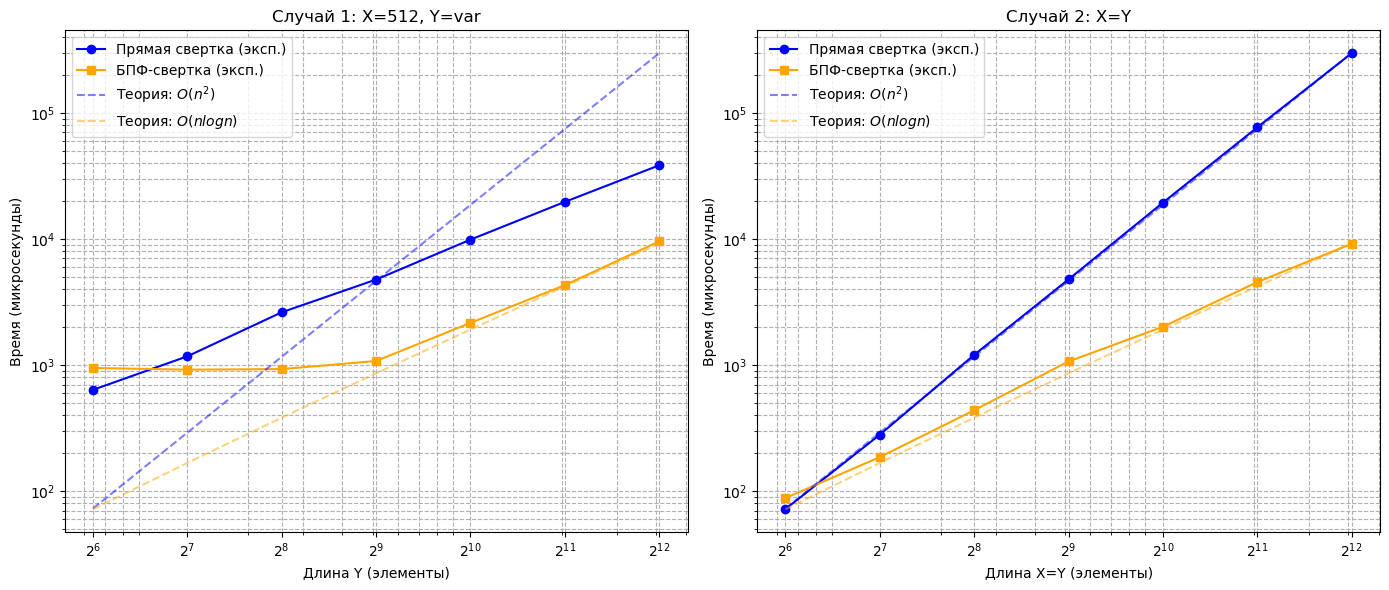

In [ ]:
n_values = np.arange(6, 13)
N_values = 2 ** n_values

# Данные времени в микросекундах 
time_direct_diff = np.array([635, 1172, 2619, 4761, 9874, 19679, 38383])    # Прямая свертка (X=512, Y=var)
time_fft_diff = np.array([947, 918, 928, 1076, 2159, 4299, 9561])          # БПФ-свертка (X=512, Y=var)
time_direct_same = np.array([72, 280, 1204, 4781, 19413, 76794, 297803])   # Прямая свертка (X=Y)
time_fft_same = np.array([88, 186, 438, 1067, 2011, 4547, 9171])          # БПФ-свертка (X=Y)

# Теоретические кривые
k_direct = time_direct_same[-1] / (N_values[-1]**2)
theory_n2 = k_direct * (N_values**2)

k_fft = time_fft_same[-1] / (N_values[-1] * np.log2(N_values[-1]))
theory_nlogn = k_fft * N_values * np.log2(N_values)

plt.figure(figsize=(14, 6))

# График для случая 1: X=512, Y=var
plt.subplot(1, 2, 1)
plt.loglog(N_values, time_direct_diff, 'o-', label='Прямая свертка (эксп.)', color='blue')
plt.loglog(N_values, time_fft_diff, 's-', label='БПФ-свертка (эксп.)', color='orange')
plt.loglog(N_values, theory_n2, '--', label='Теория: $O(n^2)$', color='blue', alpha=0.5)
plt.loglog(N_values, theory_nlogn, '--', label='Теория: $O(n log n)$', color='orange', alpha=0.5)
plt.title('Случай 1: X=512, Y=var')
plt.xlabel('Длина Y (элементы)')
plt.ylabel('Время (микросекунды)')
plt.xticks(N_values, labels=[f'$2^{{{n}}}$' for n in n_values]) 
plt.grid(True, which="both", ls="--")
plt.legend()

# График для случая 2: X=Y
plt.subplot(1, 2, 2)
plt.loglog(N_values, time_direct_same, 'o-', label='Прямая свертка (эксп.)', color='blue')
plt.loglog(N_values, time_fft_same, 's-', label='БПФ-свертка (эксп.)', color='orange')
plt.loglog(N_values, theory_n2, '--', label='Теория: $O(n^2)$', color='blue', alpha=0.5)
plt.loglog(N_values, theory_nlogn, '--', label='Теория: $O(n log n)$', color='orange', alpha=0.5)
plt.title('Случай 2: X=Y')
plt.xlabel('Длина X=Y (элементы)')
plt.ylabel('Время (микросекунды)')
plt.xticks(N_values, labels=[f'$2^{{{n}}}$' for n in n_values]) 
plt.grid(True, which="both", ls="--")
plt.legend()

plt.tight_layout()
plt.show()

**Случай 1 (X=512, Y=var)**: Прямая свертка растет квадратично, а БПФ-свертка — почти линейно (из-за доминирования фиксированного X=512).  
**Случай 2 (X=Y)**: Четко видно асимптотическое поведение двух кривых простая свертка к $O(n^2)$, а с БПФ к $O(n \log n)$.

**Прямая свертка** демонстрирует квадратичную сложность $O(n^2)$  
**БПФ-свертка** соответствует $O(n \log n)$
Для **X=512, Y=var** рост БПФ-свертки менее выражен из-за влияния фиксированного размера X.